# MAT330 - Practical work on Machine Learning
<span style="color:blue"> ** This notebook load the data and explore quickly the different features:** </span>

<span style="color:red"> ** - What is the target? ** </span>

<span style="color:red"> ** - What are the qualitative features, quantitative features? ** </span>

<span style="color:red"> ** - Which features are images? **</span>

## Example : hurricane meteorological data

Sophie Giffard-Roisin (sophie.giffard@univ-grenoble-alpes.fr)
Julien Brajard (julien.brajard@nersc.no)

## Introduction
This is an initiation to introduce regression using machine learning and get you to know how it works.

We will use a real hurricane meteorological dataset, which typical goal is to estimate the current stength of the hurricane or to predict its evolution. 
<img src="https://github.com/sophiegif/ramp_kit_storm_forecast_new/blob/master/figures_pynb/all_storms_since1979_IBTrRACKS_newcats.png?raw=true" width="70%">
<div style="text-align: center">Database: tropical/extra-tropical storm tracks since 1979. Dots = initial position, color = maximal storm strength according to the Saffir-Simpson scale.</div>


### Requirements
If you run the notebook on Colab, you don't have to install python libraries, but if you want to run the notebooks locally, you need to the followin modules:

* numpy  
* matplotlib
* pandas 
* scikit-learn   

In [1]:
%matplotlib inline
import os
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import pandas as pd

## The data

In [2]:
train_filename = 'https://raw.githubusercontent.com/brajard/MAT330-Practical-work/master/data/train.csv'
data_train = pd.read_csv(train_filename)

# Extract the predictor (but not the target -> data leakage)
X = data_train.drop('target',axis=1, inplace=False)
y = data_train['target']

In [3]:
# Do the same with the test dataset
test_filename = 'https://raw.githubusercontent.com/brajard/MAT330-Practical-work/master/data/test.csv'
Xtest = pd.read_csv(test_filename)


### 1. 0D features from track data

A set of simple features has been extracted for each storm at each time point: 

- latitude, longitude: in degrees
- windspeed: current (max) windspeed (knots) 
- hemisphere:  South=0, North=1
- Jday predictor:  Gaussian function of (Julian day of storm init - peak day of the hurricane season), see (1)
- initial_max_wind: initial (max) windspeed of the storm 
- max_wind_change_12h: last 12h (max) windspeed change
- basin = based on the present location: 
       0 = NA - North Atlantic / 1 = SA - South Atlantic    / 2 = WP - West Pacific       / 3 = EP - East Pacific /
       4 = SP - South Pacific  / 5 = NI - North Indian      / 6 = SI - South Indian       / 7 = AS - Arabian Sea /
       8 = BB - Bay of Bengal  / 9 = EA - Eastern Australia / 10 = WA - Western Australia / 11 = CP - Central Pacific
       12 = CS - Carribbean Sea/ 13 = GM - Gulf of Mexico   / 14 = MM - Missing
- nature = nature of the storm  
       0 = TS - Tropical / 1 = SS - Subtropical / 2 = ET - Extratropical / 3 = DS - Disturbance /
       4 = MX - Mix of conflicting reports / 5 = NR - Not Reported / 6 = MM - Missing / 7 =  - Missing
- dist2land = current distance to the land (km)
- target: 24h ahead windspeed (knots)


(1) DeMaria, Mark, et al. "Further improvements to the statistical hurricane intensity prediction scheme (SHIPS)." Weather and Forecasting 20.4 (2005): 531-543. https://journals.ametsoc.org/doi/full/10.1175/WAF862.1


### 2. The reanalysis data

At each time step, we extracted 7 grids (11x11 pixels) of meteorological parameters centered on the current storm location. Their choice is based on the forecast literature, on personal experience and on known hypothesis of storm strengthening.

#### a) 25x25 degree z, u and v at 700hPa-level
First, we provide 3 maps of 25 x 25 degrees (lat/long) at 700hPa-level pressure: the altitude `z`, the u-wind `u` (positive if wind from the West) and the v-wind `v` (positive if wind from the South). These grids are subsampled to 11x11 pixels (1 pixel ~=2 degrees).


In [4]:
data_train_z = X[[col for col in X.columns if col.startswith('z_')]]
data_train_z.head()

,z_0_0,z_0_1,z_0_2,z_0_3,z_0_4,z_0_5,z_0_6,z_0_7,z_0_8,z_0_9,...,z_10_1,z_10_2,z_10_3,z_10_4,z_10_5,z_10_6,z_10_7,z_10_8,z_10_9,z_10_10
0,114560.6,114579.8,114559.6,114533.2,114542.3,114558.2,114643.2,114711.4,114735.9,114748.4,...,114463.1,114524.1,114586.0,114618.7,114623.0,114614.9,114609.1,114606.2,114606.2,114603.8
1,114524.6,114515.9,114527.9,114510.2,114532.7,114519.8,114556.7,114614.9,114628.3,114648.0,...,114537.5,114588.4,114601.4,114589.9,114570.2,114556.3,114551.0,114559.6,114571.6,114577.4
2,114637.4,114609.1,114591.3,114588.4,114592.3,114603.8,114670.6,114751.7,114795.0,114798.3,...,114403.5,114454.9,114512.6,114553.4,114570.2,114580.8,114587.0,114584.1,114576.0,114570.2
3,114399.7,114393.9,114385.3,114381.4,114349.3,114373.3,114399.7,114432.8,114466.5,114522.6,...,113959.3,114033.7,114086.5,114127.4,114152.3,114162.9,114166.8,114161.5,114152.3,114149.9
4,114570.2,114561.5,114553.4,114584.6,114584.1,114584.6,114600.5,114641.3,114674.9,114717.6,...,113980.4,114068.3,114121.6,114153.8,114183.6,114207.1,114222.9,114233.0,114243.6,114226.8


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
sample_id=20 # sample number plotted - you can change it to see other storms and other instants
grid_l=11 # size of all 2D-grids (in pixels)

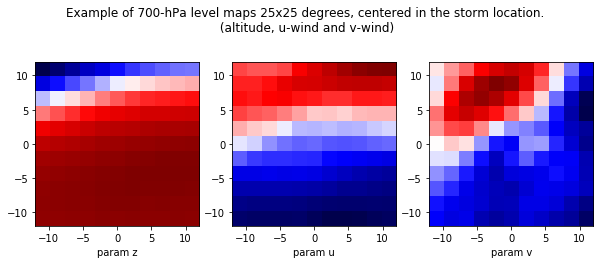

In [6]:
params_25x25=['z','u','v']
plt.figure(figsize=(10,4))
for p,param in enumerate(params_25x25):
    image=np.zeros([grid_l,grid_l])
    for i in range(grid_l):
         for j in range(grid_l):
            image[i,j]=X[param+'_'+str(i)+'_'+str(j)][sample_id]
    plt.subplot(1,3,p+1)
    plt.imshow(np.array(image),extent=[-12,12,-12,12],
               interpolation='nearest', origin='lower', cmap='seismic')
    plt.xlabel('param '+param)
t=plt.suptitle('Example of 700-hPa level maps 25x25 degrees, centered in the storm location.'
         +'\n (altitude, u-wind and v-wind)')